In [18]:
import numpy as np
import scipy.signal as sp_signal
import matplotlib.pyplot as plt
import pandas as pd
import json

# **1. 加载数据**
def load_csi_data(file_path):
    """
    加载和解析 CSI 数据集
    :param file_path: CSV 文件路径
    :return: DataFrame，包含元数据和解析后的 CSI 数据
    """
    # 加载 CSV 文件
    df = pd.read_csv(file_path)
    
    # 提取 CSI 数据列并解析
    def parse_csi_data(csi_string):
        try:
            # 将字符串形式的 CSI 数据解析为 NumPy 数组
            return np.array(json.loads(csi_string))
        except json.JSONDecodeError as e:
            print(f"Error parsing CSI data: {e}")
            return np.nan  # 如果解析失败，返回 NaN

    # 解析 `data` 列
    df['csi_array'] = df['data'].apply(parse_csi_data)
    
    return df

# **2. 预处理数据**
def preprocess_csi_data(csi_data, metric="amplitude"):
    """
    从 CSI 数据中提取幅度或相位，并进行预处理
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param metric: 选择 "amplitude" 或 "phase" 作为提取指标
    :return: 提取后的信号数组，形状为 (N, M)，N 为采样点数，M 为子载波数量
    """
    num_subcarriers = len(csi_data.iloc[0]) // 2  # 每个采样点的子载波数量
    processed_data = []

    for csi in csi_data:
        subcarrier_values = []
        for subcarrier_idx in range(num_subcarriers):
            # 提取子载波的虚部和实部
            imaginary = csi[subcarrier_idx * 2]
            real = csi[subcarrier_idx * 2 + 1]

            # 计算幅度或相位
            if metric == "amplitude":
                subcarrier_values.append(np.sqrt(imaginary**2 + real**2))  # 计算幅度
            elif metric == "phase":
                subcarrier_values.append(np.arctan2(imaginary, real))  # 计算相位

        processed_data.append(subcarrier_values)
    
    print(np.array(processed_data).shape)  # 输出形状
    return np.array(processed_data)  # 返回形状为 (N, M) 的二维数组

# **3. 分别对每个子载波进行 FFT，再取平均**
def estimate_breathing_rate(signal_matrix, fs):
    """
    从信号矩阵中估计呼吸频率
    :param signal_matrix: 预处理后的信号矩阵，形状为 (N, M)，N 为采样点数，M 为子载波数量
    :param fs: 采样率 (Hz)
    :return: 呼吸频率 (BPM)
    """
    num_subcarriers = signal_matrix.shape[1]
    fft_results = []

    # Step 1: 对每个子载波分别执行 FFT
    for subcarrier_idx in range(num_subcarriers):
        subcarrier_signal = signal_matrix[:, subcarrier_idx]
        fft_values = np.fft.rfft(subcarrier_signal)  # 对子载波信号执行 FFT
        fft_results.append(np.abs(fft_values))  # 获取振幅

    # Step 2: 对所有子载波的 FFT 结果取平均
    fft_mean = np.mean(fft_results, axis=0)  # 对每个频率点取平均
    
    freqs = np.fft.rfftfreq(signal_matrix.shape[0], 1/fs)  # 计算频率轴

    # Step 3: 找到主频
    max_index = np.argmax(fft_mean)  # 幅值最大的位置
    dominant_frequency = freqs[max_index]  # 主频率 (Hz)

    # 转换为 BPM
    breathing_rate_bpm = dominant_frequency * 60
    return round(breathing_rate_bpm)

# **4. 实时监测呼吸频率**
def monitor_breathing_rate(csi_data, fs, window_size, step_size, metric="amplitude"):
    """
    实时监测呼吸频率
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param fs: 采样率 (Hz)
    :param window_size: 滑动窗口大小（秒）
    :param step_size: 滑动步长（秒）
    :param metric: 选择 "amplitude" 或 "phase" 作为提取指标
    :return: 呼吸频率随时间变化的列表
    """
    # Step 1: 提取信号矩阵
    signal_matrix = preprocess_csi_data(csi_data, metric)  # 返回形状 (N, M)

    # Step 2: 滤波，保留呼吸相关频率范围（6-30 BPM 对应 0.1-0.5 Hz）
    b, a = sp_signal.butter(4, [0.1, 0.5], btype='bandpass', fs=fs)
    filtered_signal = sp_signal.filtfilt(b, a, signal_matrix, axis=0)  # 对每个子载波滤波

    # Step 3: 滑动窗口估计呼吸频率
    window_samples = int(window_size * fs)
    step_samples = int(step_size * fs)
    rates = []

    for start in range(0, filtered_signal.shape[0] - window_samples, step_samples):
        window_signal = filtered_signal[start:start + window_samples, :]  # 获取窗口内的数据
        rate = estimate_breathing_rate(window_signal, fs)  # 对窗口数据估计呼吸频率
        rates.append(rate)

    return rates

# **5. 绘制呼吸频率随时间变化的曲线**
def plot_breathing_rate(rates, step_size):
    """
    绘制呼吸频率随时间变化的图表
    :param rates: 呼吸频率列表 (BPM)
    :param step_size: 滑动步长（秒）
    """
    time_axis = np.arange(0, len(rates) * step_size, step_size)
    plt.plot(time_axis, rates, marker='o')
    plt.title("Breathing Rate Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Breathing Rate (BPM)")
    plt.grid()
    plt.show()

# **6. 评估函数*
def load_ground_truth(gt_file_path):
    """
    加载ground truth数据
    :param gt_file_path: ground truth CSV文件路径
    :return: 呼吸率真实值数组
    """
    gt_df = pd.read_csv(gt_file_path)
    return gt_df['breathing_rate'].values

def calculate_mae(predicted_rates, ground_truth):
    """
    计算平均绝对误差 (MAE)
    """
    return np.mean(np.abs(np.array(predicted_rates) - ground_truth))

def plot_comparison(predicted_rates, ground_truth, step_size):
    """
    绘制预测值和真实值的对比图
    """
    time_axis = np.arange(len(predicted_rates)) * step_size
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, predicted_rates, 'b-', label='Predicted')
    plt.plot(time_axis, ground_truth, 'r--', label='Ground Truth')
    plt.xlabel('Time (s)')
    plt.ylabel('Breathing Rate (BPM)')
    plt.title('Predicted vs Ground Truth Breathing Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


Inspecting ground truth file structure:
Ground truth file columns: Index(['bpm', 'time'], dtype='object')

First few rows of the data:
         bpm                 time
0  14.457831  2025-02-27 19:11:32
1  14.778325  2025-02-27 19:11:33
2  14.598540  2025-02-27 19:11:34
3  15.113350  2025-02-27 19:11:34
4  15.503876  2025-02-27 19:11:35
(5004, 117)
Mean Absolute Error: 7.64 BPM
Accuracy within ±2 BPM: 3.08%
Average Predicted Rate: 7.94 BPM
Average Ground Truth Rate: 15.45 BPM


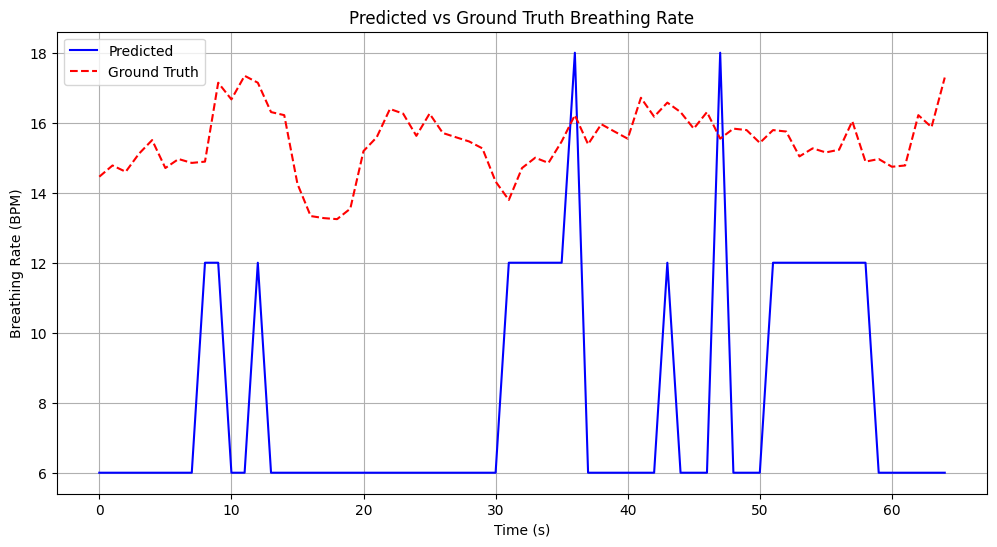

In [19]:
# 先查看ground truth文件的内容和结构
def inspect_gt_file(gt_file_path):
    gt_df = pd.read_csv(gt_file_path)
    print("Ground truth file columns:", gt_df.columns)
    print("\nFirst few rows of the data:")
    print(gt_df.head())
    return gt_df

# 修改load_ground_truth函数以适应不同的列名
def load_ground_truth(gt_file_path):
    """
    加载ground truth数据
    :param gt_file_path: ground truth CSV文件路径
    :return: 呼吸率真实值数组
    """
    gt_df = pd.read_csv(gt_file_path)
    
    # 检查可能的列名
    possible_columns = ['breathing_rate', 'bpm', 'rate', 'ground_truth']
    
    for col in possible_columns:
        if col in gt_df.columns:
            return gt_df[col].values
    
    # 如果没有找到预期的列名，打印所有可用的列名并抛出错误
    print("Available columns in the ground truth file:", gt_df.columns)
    raise KeyError(f"Could not find breathing rate column. Available columns are: {gt_df.columns}")

# 在main中使用
if __name__ == "__main__":
    # 设置文件路径
    base_path = "C:/Users/Bob/Desktop/comp7310_2025_group_project/benchmark/breathing_rate/evaluation/"
    csi_file = "CSI20250227_191018.csv"
    gt_file = "gt_20250227_191018.csv"
    
    csi_path = base_path + csi_file
    gt_path = base_path + gt_file

    # 首先检查ground truth文件的结构
    print("Inspecting ground truth file structure:")
    gt_df = inspect_gt_file(gt_path)
    
    # 加载数据
    csi_df = load_csi_data(csi_path)
    ground_truth = load_ground_truth(gt_path)

    # 设置参数
    window_size = 10  # 滑动窗口大小（秒）
    step_size = 1    # 滑动步长（秒）
    fs = 50          # 采样率 (Hz)

    # 获取预测值
    predicted_rates = monitor_breathing_rate(csi_df['csi_array'], fs, window_size, step_size, metric="amplitude")

    # 确保预测值和真实值长度匹配
    min_length = min(len(predicted_rates), len(ground_truth))
    predicted_rates = predicted_rates[:min_length]
    ground_truth = ground_truth[:min_length]

    # 计算MAE
    mae = calculate_mae(predicted_rates, ground_truth)
    print(f"Mean Absolute Error: {mae:.2f} BPM")

    # 计算准确率（在允许误差范围内的百分比）
    tolerance = 2  # 允许误差范围（例如±2 BPM）
    accuracy = np.mean(np.abs(np.array(predicted_rates) - ground_truth) <= tolerance) * 100
    print(f"Accuracy within ±{tolerance} BPM: {accuracy:.2f}%")

    # 显示平均值
    print(f"Average Predicted Rate: {np.mean(predicted_rates):.2f} BPM")
    print(f"Average Ground Truth Rate: {np.mean(ground_truth):.2f} BPM")

    # 绘制对比图
    plot_comparison(predicted_rates, ground_truth, step_size)

In [8]:
import numpy as np
import scipy.signal as sp_signal
import matplotlib.pyplot as plt
import pandas as pd
import json

# **1. 加载数据**
def load_csi_data(file_path):
    """
    加载和解析 CSI 数据集
    :param file_path: CSV 文件路径
    :return: DataFrame，包含元数据和解析后的 CSI 数据
    """
    # 加载 CSV 文件
    df = pd.read_csv(file_path)
    
    # 提取 CSI 数据列并解析
    def parse_csi_data(csi_string):
        try:
            # 将字符串形式的 CSI 数据解析为 NumPy 数组
            return np.array(json.loads(csi_string))
        except json.JSONDecodeError as e:
            print(f"Error parsing CSI data: {e}")
            return np.nan  # 如果解析失败，返回 NaN

    # 解析 `data` 列
    df['csi_array'] = df['data'].apply(parse_csi_data)
    
    return df

# **2. 预处理数据**
def preprocess_csi_data(csi_data, metric="amplitude"):
    """
    从 CSI 数据中提取幅度或相位，并进行预处理
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param metric: 选择 "amplitude" 或 "phase" 作为提取指标
    :return: 提取后的信号数组，形状为 (N, M)，N 为采样点数，M 为子载波数量
    """
    num_subcarriers = len(csi_data.iloc[0]) // 2  # 每个采样点的子载波数量
    processed_data = []

    for csi in csi_data:
        subcarrier_values = []
        for subcarrier_idx in range(num_subcarriers):
            # 提取子载波的虚部和实部
            imaginary = csi[subcarrier_idx * 2]
            real = csi[subcarrier_idx * 2 + 1]

            # 计算幅度或相位
            if metric == "amplitude":
                subcarrier_values.append(np.sqrt(imaginary**2 + real**2))  # 计算幅度
            elif metric == "phase":
                subcarrier_values.append(np.arctan2(imaginary, real))  # 计算相位

        processed_data.append(subcarrier_values)
    
    print(np.array(processed_data).shape)  # 输出形状
    return np.array(processed_data)  # 返回形状为 (N, M) 的二维数组

# **3. 分别对每个子载波进行 FFT，再取平均**
def estimate_breathing_rate_acf(signal_matrix, fs):
    """
    使用 ACF（自相关函数）从信号矩阵中估计呼吸频率
    :param signal_matrix: 预处理后的信号矩阵，形状为 (N, M)，N 为采样点数，M 为子载波数量
    :param fs: 采样率 (Hz)
    :return: 呼吸频率 (BPM)
    """
    num_subcarriers = signal_matrix.shape[1]
    acf_results = []

    # Step 1: 对每个子载波分别计算 ACF
    for subcarrier_idx in range(num_subcarriers):
        subcarrier_signal = signal_matrix[:, subcarrier_idx]
        
        # 计算自相关函数（ACF）
        acf = np.correlate(subcarrier_signal, subcarrier_signal, mode='full')
        acf = acf[acf.size // 2:]  # 只保留正半部分
        acf_results.append(acf)

    # Step 2: 对所有子载波的 ACF 结果取平均
    acf_mean = np.mean(acf_results, axis=0)  # 对每个延迟点取平均

    # Step 3: 找到主周期
    peaks = np.diff(acf_mean)  # 计算一阶差分
    peaks = np.where((peaks[:-1] > 0) & (peaks[1:] < 0))[0] + 1  # 找到峰值位置

    if len(peaks) == 0:  # 如果没有找到峰值，返回 0
        return 0

    # 计算主周期（以样本点为单位）
    dominant_period = peaks[0]  # 第一个峰值对应的延迟时间（样本点数）

    # 转换为主频率 (Hz)
    dominant_frequency = fs / dominant_period  # 频率 = 采样率 / 周期

    # 转换为 BPM
    breathing_rate_bpm = dominant_frequency * 60
    return round(breathing_rate_bpm)

# **4. 实时监测呼吸频率**
def monitor_breathing_rate(csi_data, fs, window_size=10, step_size=1, metric="amplitude"):
    """
    实时监测呼吸频率
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param fs: 采样率 (Hz)
    :param window_size: 滑动窗口大小（秒），默认 10 秒
    :param step_size: 滑动步长（秒），默认 1 秒
    :param metric: 选择 "amplitude" 或 "phase" 作为提取指标
    :return: 呼吸频率随时间变化的列表
    """
    signal_matrix = preprocess_csi_data(csi_data, metric)  # 提取信号矩阵
    rates = []
    window_size_samples = int(window_size * fs)  # 滑动窗口大小，单位为采样点
    step_size_samples = int(step_size * fs)  # 滑动步长，单位为采样点

    for start_idx in range(0, len(signal_matrix) - window_size_samples + 1, step_size_samples):
        # 提取窗口信号
        window_signal = signal_matrix[start_idx:start_idx + window_size_samples, :]

        # 检查窗口信号是否有效
        if len(window_signal) < window_size_samples or np.allclose(window_signal, window_signal[0], atol=1e-6):
            continue

        # 滤波处理
        lowcut, highcut = 0.1, 0.5  # 呼吸频率范围 (Hz)
        nyquist = fs / 2
        if highcut >= nyquist or lowcut <= 0:
            continue
        b, a = butter(4, [lowcut / nyquist, highcut / nyquist], btype='bandpass')

        try:
            filtered_signal = filtfilt(b, a, window_signal, axis=0)
        except Exception:
            continue

        # 使用自相关函数估计呼吸频率
        rate = estimate_breathing_rate_acf(filtered_signal, fs)
        rates.append(rate)

    return rates

# **5. 绘制呼吸频率随时间变化的曲线**
def plot_breathing_rate(rates, step_size):
    """
    绘制呼吸频率随时间变化的曲线
    :param rates: 呼吸频率列表
    :param step_size: 滑动步长（秒）
    """
    # 生成时间轴
    time_axis = [i * step_size for i in range(len(rates))]
    
    # 绘制曲线
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, rates, marker='o', linestyle='-', color='blue', label='Breathing Rate')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Breathing Rate (BPM)', fontsize=12)
    plt.title('Breathing Rate Over Time', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:

import numpy as np
import scipy.signal as sp_signal
import matplotlib.pyplot as plt
import pandas as pd
import json

# **1. 加载数据**
def load_csi_data(file_path):
    """
    加载和解析 CSI 数据集
    :param file_path: CSV 文件路径
    :return: DataFrame，包含元数据和解析后的 CSI 数据
    """
    # 加载 CSV 文件
    df = pd.read_csv(file_path)
    
    # 提取 CSI 数据列并解析
    def parse_csi_data(csi_string):
        try:
            # 将字符串形式的 CSI 数据解析为 NumPy 数组
            return np.array(json.loads(csi_string))
        except (json.JSONDecodeError, TypeError) as e:
            print(f"Error parsing CSI data: {e}")
            return np.nan  # 如果解析失败，返回 NaN

    # 解析 `data` 列
    df['csi_array'] = df['data'].apply(parse_csi_data)
    
    # 删除无效行
    df = df.dropna(subset=['csi_array']).reset_index(drop=True)
    return df

# **2. 预处理数据**
def preprocess_csi_data(csi_data, metric="amplitude"):
    """
    从 CSI 数据中提取幅度或相位，并进行预处理
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param metric: 选择 "amplitude" 或 "phase" 作为提取指标
    :return: 提取后的信号数组，形状为 (N, M)，N 为采样点数，M 为子载波数量
    """
    num_subcarriers = len(csi_data.iloc[0]) // 2  # 每个采样点的子载波数量
    processed_data = []

    for csi in csi_data:
        subcarrier_values = []
        for subcarrier_idx in range(num_subcarriers):
            # 提取子载波的虚部和实部
            imaginary = csi[subcarrier_idx * 2]
            real = csi[subcarrier_idx * 2 + 1]

            # 计算幅度或相位
            if metric == "amplitude":
                subcarrier_values.append(np.sqrt(imaginary**2 + real**2))  # 计算幅度
            elif metric == "phase":
                subcarrier_values.append(np.arctan2(imaginary, real))  # 计算相位

        processed_data.append(subcarrier_values)
    
    return np.array(processed_data)  # 返回形状为 (N, M) 的二维数组

# **3. 利用 ACF 估计呼吸频率**
def estimate_breathing_rate_acf(signal_matrix, fs):
    """
    使用 ACF（自相关函数）从信号矩阵中估计呼吸频率
    :param signal_matrix: 预处理后的信号矩阵，形状为 (N, M)，N 为采样点数，M 为子载波数量
    :param fs: 采样率 (Hz)
    :return: 呼吸频率 (BPM)
    """
    num_subcarriers = signal_matrix.shape[1]
    acf_results = []

    # Step 1: 对每个子载波分别计算 ACF
    for subcarrier_idx in range(num_subcarriers):
        subcarrier_signal = signal_matrix[:, subcarrier_idx]
        
        # 计算自相关函数（ACF）
        acf = np.correlate(subcarrier_signal, subcarrier_signal, mode='full')
        acf = acf[acf.size // 2:]  # 只保留正半部分
        acf_results.append(acf)

    # Step 2: 对所有子载波的 ACF 结果取平均
    acf_mean = np.mean(acf_results, axis=0)  # 对每个延迟点取平均

    # Step 3: 找到主周期
    peaks = np.diff(acf_mean)  # 计算一阶差分
    peaks = np.where((peaks[:-1] > 0) & (peaks[1:] < 0))[0] + 1  # 找到峰值位置

    if len(peaks) == 0:  # 如果没有找到峰值，返回 0
        print("Warning: No peaks found in ACF. Returning 0 BPM.")
        return 0

    # 计算主周期（以样本点为单位）
    dominant_period = peaks[0]  # 第一个峰值对应的延迟时间（样本点数）

    # 转换为主频率 (Hz)
    dominant_frequency = fs / dominant_period  # 频率 = 采样率 / 周期

    # 转换为 BPM
    breathing_rate_bpm = dominant_frequency * 60
    return round(breathing_rate_bpm)

# **4. 实时监测呼吸频率**
def monitor_breathing_rate(csi_data, fs, window_size=10, step_size=1, metric="amplitude"):
    """
    实时监测呼吸频率
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param fs: 采样率 (Hz)
    :param window_size: 滑动窗口大小（秒），默认 10 秒
    :param step_size: 滑动步长（秒），默认 1 秒
    :param metric: 选择 "amplitude" 或 "phase" 作为提取指标
    :return: 呼吸频率随时间变化的列表
    """
    signal_matrix = preprocess_csi_data(csi_data, metric)  # 提取信号矩阵
    rates = []
    window_size_samples = int(window_size * fs)  # 滑动窗口大小，单位为采样点
    step_size_samples = int(step_size * fs)  # 滑动步长，单位为采样点

    for start_idx in range(0, len(signal_matrix) - window_size_samples + 1, step_size_samples):
        # 提取窗口信号
        window_signal = signal_matrix[start_idx:start_idx + window_size_samples, :]

        # 检查窗口信号是否有效
        if len(window_signal) < window_size_samples or np.allclose(window_signal, window_signal[0], atol=1e-6):
            continue

        # 滤波处理
        lowcut, highcut = 0.15, 0.5  # 呼吸频率范围 (Hz)
        nyquist = fs / 2
        if highcut >= nyquist or lowcut <= 0:
            continue
        b, a = sp_signal.butter(4, [lowcut / nyquist, highcut / nyquist], btype='bandpass')

        try:
            filtered_signal = sp_signal.filtfilt(b, a, window_signal, axis=0)
        except Exception as e:
            print(f"Filtering error: {e}")
            continue

        # 使用自相关函数估计呼吸频率
        rate = estimate_breathing_rate_acf(filtered_signal, fs)
        rates.append(rate)

    return rates

# **5. 绘制呼吸频率随时间变化的曲线**
def plot_breathing_rate(rates, step_size):
    """
    绘制呼吸频率随时间变化的曲线
    :param rates: 呼吸频率列表
    :param step_size: 滑动步长（秒）
    """
    # 生成时间轴
    time_axis = [i * step_size for i in range(len(rates))]
    
    # 绘制曲线
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, rates, marker='o', linestyle='-', color='blue', label='Breathing Rate')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Breathing Rate (BPM)', fontsize=12)
    plt.title('Breathing Rate Over Time', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# **6. 主函数**
if __name__ == "__main__":
    # 替换为你的数据文件路径
    file_path = "C:/Users/Bob/Desktop/comp7310_2025_group_project/benchmark/breathing_rate/evaluation/CSI20250227_191018.csv"

    # 加载数据
    csi_df = load_csi_data(file_path)

    # 调用监测函数
    window_size = 10  # 滑动窗口大小（秒）
    step_size = 1  # 滑动步长（秒）
    fs = 50  # 采样率 (Hz)

    # 监测呼吸频率
    rates = monitor_breathing_rate(csi_df['csi_array'], fs, window_size, step_size, metric="amplitude")

    # 检查和打印数据
    print("Parsed CSI data:")
    print(csi_df['csi_array'].head())

    # 输出平均呼吸频率
    print("Estimated Breathing Rates (BPM):", rates)
    average_rate = np.mean(rates)
    print(f"Average Breathing Rate: {round(average_rate)} BPM")

    # 绘制呼吸频率随时间变化的曲线
    plot_breathing_rate(rates, step_size)

KeyError: 'breathing_rate'